# Policy Evaluation and Robustness Analysis

In this notebook, the Pareto-optimal polices from the MOEA are further evaluated on robustness. This is done by: 
- computing a signal-to-noise ratio for each outcome,which balances average effectiveness with consistency
- quantifying policy regret, which measures how much worse each policy performs compared to the best possible outcome in each scenario.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from ema_workbench import (
    Policy, MultiprocessingEvaluator, save_results, load_results, ScalarOutcome)
from ema_workbench.analysis import parcoords, prim
from problem_formulation import get_model_for_problem_formulation

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


**Import the policies and model**

In [3]:
# Load Pareto-optimal policies from CSV file
pareto_policies = pd.read_csv('Policies_filtered_on_deaths.csv')
# Load the dike model and its steps for the specified problem formulation (formulation 2)
dike_model, steps = get_model_for_problem_formulation(2)

# Creating Policies and Running Experiments

The Pareto-optimal policies are converted into EMA Workbench Policy objects with unique names. Using a MultiprocessingEvaluator, the dike model is then run for 1000 scenarios per policy, generating results that capture each policy’s performance under uncertainty.

In [4]:
policy_list = []

# Convert each row in pareto_policies DataFrame into an EMA Workbench Policy object
for i, policy in pareto_policies.iterrows():
    policy_dictionary = policy.to_dict()  # Convert policy row to dictionary
    name = f"policy_{i}"  # Create a unique policy name
    # Create Policy object with name and parameters, then add to the list
    policy_list.append(Policy(name=name, **policy_dictionary))

In [5]:
# Define the number of uncertain scenarios to simulate for each policy
n_scenarios = 1000

# Use parallel processing to efficiently run the dike model experiments
with MultiprocessingEvaluator(dike_model) as evaluator:
    # Perform experiments for all policies across the specified number of scenarios
    results = evaluator.perform_experiments(
        scenarios=n_scenarios, policies=policy_list)

100%|████████████████████████████████| 261000/261000 [1:49:57<00:00, 39.56it/s]


# Computing Signal-to-Noise Ratios for Policy Outcomes

A function is made that calculates the signal-to-noise ratio (SNR) for each outcome. This balances mean performance against variability. For outcomes to be maximized, the ratio is mean divided by standard deviation; for those to minimize, it is mean multiplied by standard deviation.

Using this function, we compute SNR scores for all policies across all outcomes, creating a summary DataFrame. These scores are then visualized using parallel coordinate plots.

In [7]:
def signal_to_noise(data, direction):
    # Calculate mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # Avoid division by zero by setting std to 1 if it is zero
    if std == 0:
        std = 1

    # For outcomes to maximize: use mean divided by std (higher is better)
    if direction == ScalarOutcome.MAXIMIZE:
        return mean / std
    else:
        # For outcomes to minimize: use mean multiplied by std (lower is better)
        return mean * std

In [8]:
# Unpack experiments and outcomes from results
experiments, outcomes = results

overall_scores = {}

# Loop through each unique policy to calculate signal-to-noise ratios
for i in np.unique(experiments['policy']):
    scores = {}
    # Select rows for current policy
    select_policy = experiments['policy'] == i

    # Calculate signal-to-noise ratio for each outcome of the policy
    for j in dike_model.outcomes:
        x = outcomes[j.name][select_policy]  # Outcome values for this policy
        ratio = signal_to_noise(x, j.kind)   # Compute signal-to-noise ratio
        scores[j.name] = ratio

    overall_scores[i] = scores  # Store scores per policy

# Convert the overall scores dictionary to a DataFrame for easier analysis
scores_df = pd.DataFrame.from_dict(overall_scores).T
scores_df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
policy_0,1.892616e+17,2.128818e+08,176700000.0,1.989473e+07,0.011345
policy_1,2.332154e+17,1.992504e+08,61400000.0,9.007492e+07,0.001631
policy_10,3.451860e+17,1.305046e+00,419100000.0,1.061729e+08,0.002156
policy_100,1.265190e+18,4.358308e+00,182600000.0,1.862290e+08,0.008480
policy_101,3.119653e+17,4.062605e+00,509600000.0,8.196671e+07,0.002042
...,...,...,...,...,...
policy_95,1.263006e+18,1.299411e+08,303800000.0,1.165538e+08,0.013012
policy_96,3.407246e+17,1.446809e+00,540300000.0,6.292690e+07,0.004090
policy_97,1.259552e+18,5.904153e+00,303800000.0,1.759542e+08,0.008316
policy_98,1.250902e+18,1.777407e+01,213300000.0,3.780737e+07,0.072922


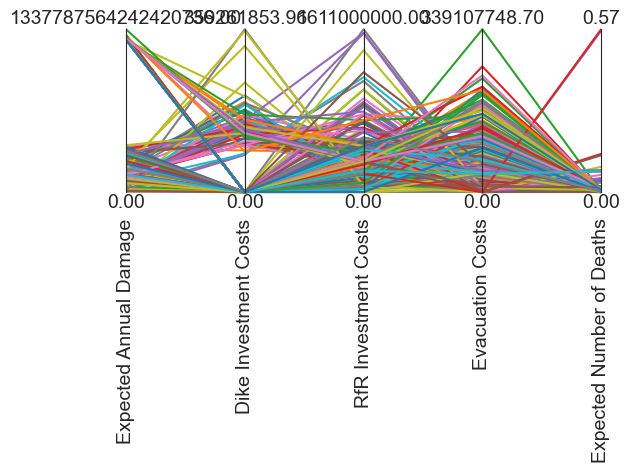

In [9]:
# Get axis limits for parallel coordinates plot based on the scores DataFrame
limits = parcoords.get_limits(scores_df)

# Set the lower bounds for selected cost and damage outcomes to zero for better visualization
limits.loc[0, ['Expected Annual Damage', 'Expected Number of Deaths',
               'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']] = 0

# Create parallel axes object using the calculated limits
axes = parcoords.ParallelAxes(limits)

# Plot the signal-to-noise ratio scores for all policies on parallel coordinates
axes.plot(scores_df)

# Display the plot
plt.show()

# Filtering Policies and Analyzing Regret

First 2000 policies are filtered out on the highest expected number of deaths to focus on safer options. Then these results are merged into a single dataframe.

With these results the regret for each outcome by scenario and policy is computed. This is defined as the difference between the best-performing policy in that scenario and each policy's performance. 



In [25]:
# Remove the 70 policies with the highest expected number of deaths to focus on safer options
filtered_scores = scores_df.drop(
    scores_df['Expected Number of Deaths'].nlargest(200).index)

# Print the number of remaining policies after filtering
print(len(filtered_scores))

# Reset the index to convert policy names from the index into a column
filtered_policies = filtered_scores.reset_index()

# Extract the policy names as a list for further filtering or analysis
filtered_policies = filtered_policies.iloc[:, 0]
filtered_policies.tolist()

61


['policy_120',
 'policy_126',
 'policy_129',
 'policy_133',
 'policy_138',
 'policy_142',
 'policy_145',
 'policy_148',
 'policy_149',
 'policy_15',
 'policy_150',
 'policy_152',
 'policy_158',
 'policy_159',
 'policy_160',
 'policy_161',
 'policy_164',
 'policy_165',
 'policy_168',
 'policy_169',
 'policy_176',
 'policy_177',
 'policy_179',
 'policy_182',
 'policy_184',
 'policy_186',
 'policy_187',
 'policy_188',
 'policy_190',
 'policy_196',
 'policy_197',
 'policy_198',
 'policy_2',
 'policy_201',
 'policy_202',
 'policy_204',
 'policy_205',
 'policy_217',
 'policy_218',
 'policy_220',
 'policy_223',
 'policy_225',
 'policy_227',
 'policy_234',
 'policy_235',
 'policy_236',
 'policy_237',
 'policy_239',
 'policy_243',
 'policy_246',
 'policy_248',
 'policy_250',
 'policy_254',
 'policy_258',
 'policy_259',
 'policy_260',
 'policy_32',
 'policy_37',
 'policy_4',
 'policy_58',
 'policy_7']

In [26]:
# Create merged results DataFrame
results_df = pd.DataFrame(experiments).copy()
for k, v in outcomes.items():
    results_df[k] = v

# Filter for best policies
best_results = results_df[results_df['policy'].isin(filtered_policies)]

In [27]:
# Preallocate regret storage
overall_regret = {}
max_regret = {}

# Loop through each outcome
for outcome in dike_model.outcomes:
    name = outcome.name

    # Pivot data to get outcome values by [scenario, policy]
    pivot = best_results.pivot(index='scenario', columns='policy', values=name)

    # Compute regret: max value in each row (scenario) minus each policy's value
    regret_matrix = (pivot.max(axis=1).values[:, np.newaxis] - pivot).abs()

    # Store results
    overall_regret[name] = regret_matrix
    max_regret[name] = regret_matrix.max()

The maximum regret values are summarized and visualized using a heatmap to highlight outcomes and policies with the greatest potential loss.

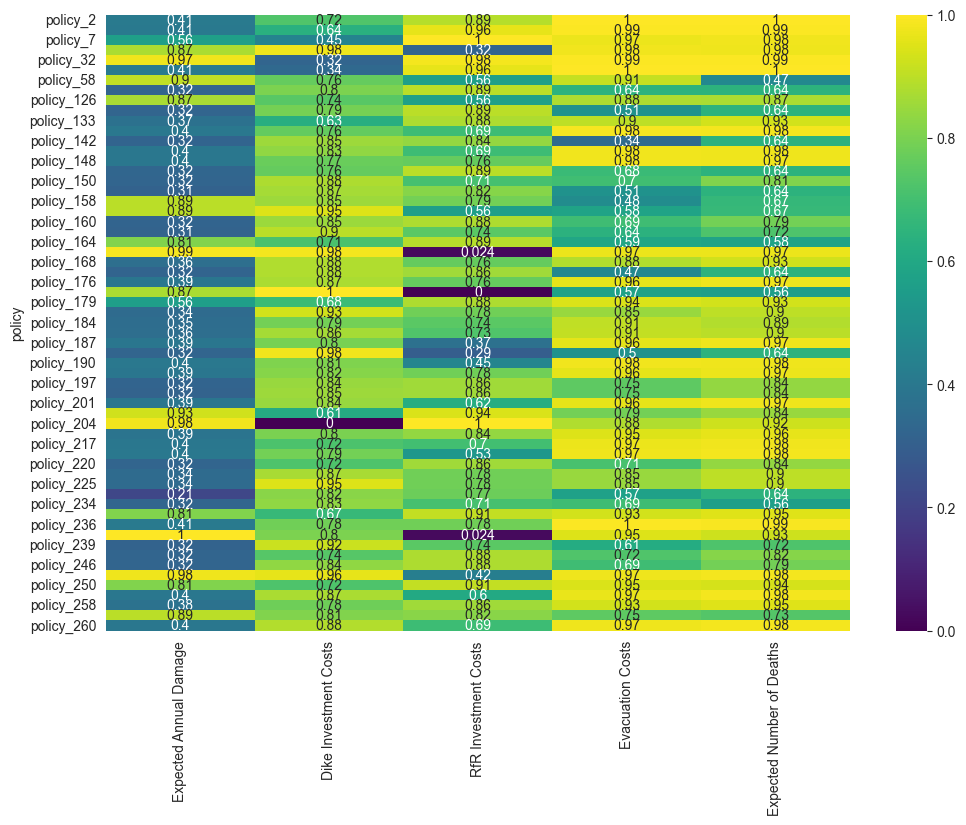

In [29]:


# Convert max_regret dictionary to a DataFrame for easier visualization
max_regret = pd.DataFrame(max_regret)

# Normalize the regret values by dividing by the maximum regret per outcome
normalized_regret = max_regret / max_regret.max()

# Set the figure size (width, height in inches)
plt.figure(figsize=(12, 8))  # You can adjust these numbers to suit your needs

# Plot the heatmap
sns.heatmap(normalized_regret, cmap='viridis', annot=True)

# Display the heatmap
plt.show()

The parallel coordinate plots display regret across selected key outcomes, allowing for multi-dimensional comparison of policy robustness.

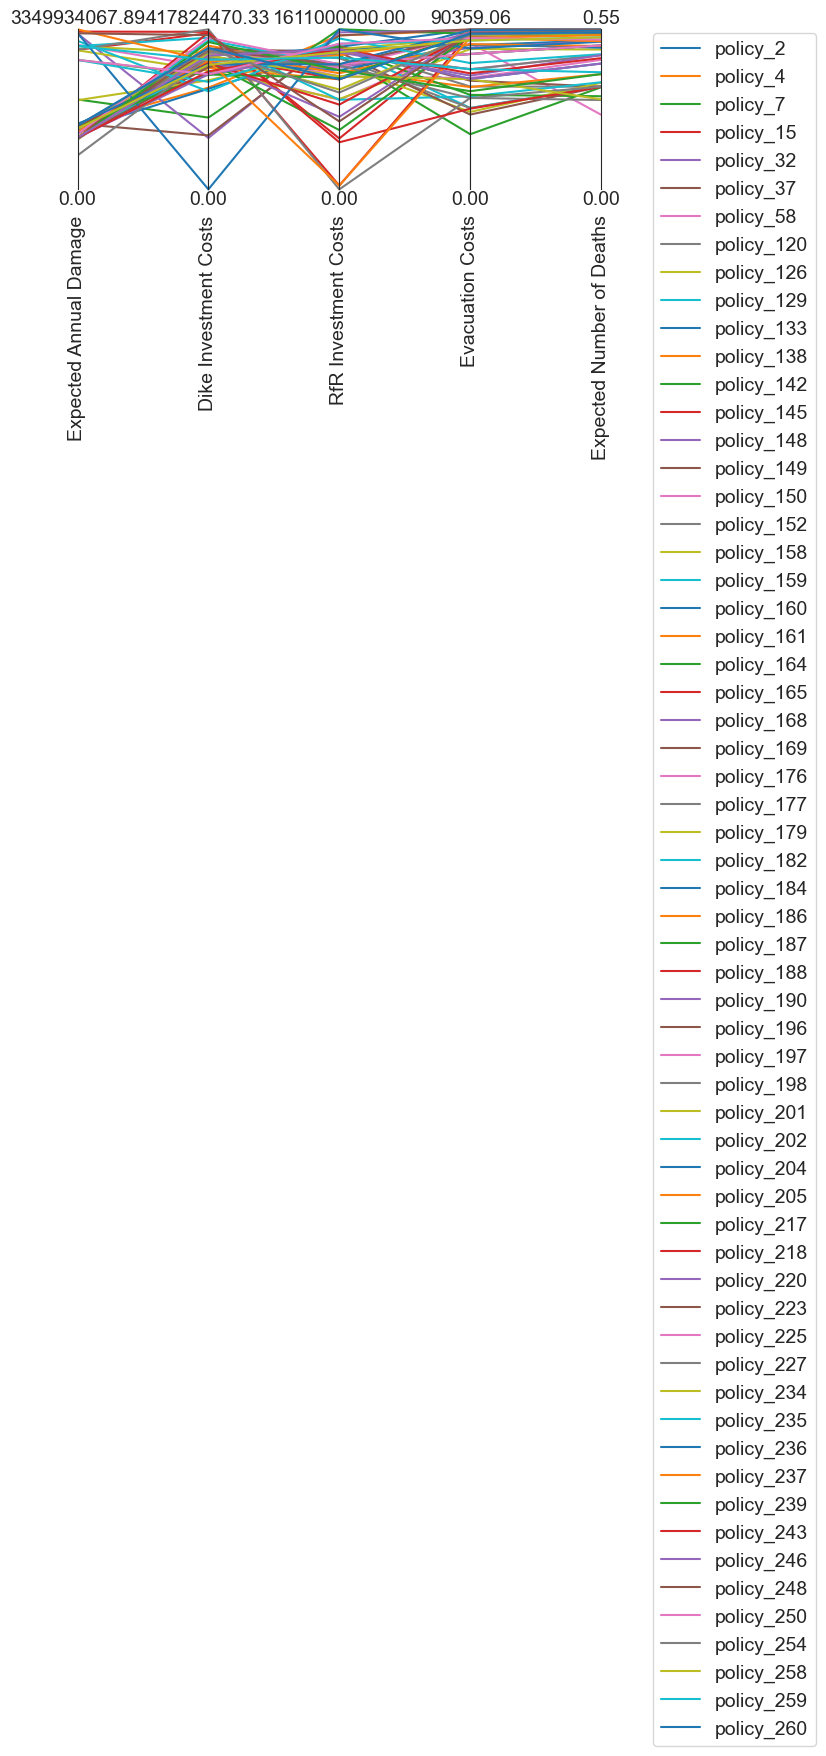

In [30]:
# Select key outcomes for detailed regret analysis
selected_outcomes = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

# Create a copy of max_regret DataFrame filtered to selected outcomes
data = max_regret[selected_outcomes].copy()

# Generate a distinct color palette with one color per policy
colors = sns.color_palette(n_colors=len(data))

# Get axis limits for parallel coordinates plot based on the data
limits = parcoords.get_limits(data)

# Set lower bounds for all selected outcomes to zero to improve plot clarity
limits.loc[0, selected_outcomes] = 0

# Initialize parallel coordinates plot with specified limits
paraxes = parcoords.ParallelAxes(limits)

# Plot each policy’s regret profile with a unique color and label
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

# Add a legend to identify policies
paraxes.legend()

# Display the parallel coordinates plot
plt.show()

# Summarizing Policy Robustness and Visualizing Trade-offs

We calculate average investment, damages, and deaths for each policy across scenarios. These metrics are plotted to show trade-offs between cost and risk, helping identify robust policies that balance investment and impact

In [15]:
# Initialize a nested dictionary to store regret values by policy and outcome
policy_regret = defaultdict(dict)

# Loop over each outcome and its regret matrix
for key, value in overall_regret.items():
    # For each policy in the regret matrix, store its regret for the given outcome
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [16]:
# Initialize dictionary to store outcome DataFrames grouped by policy
all_policy_outcome_dfs = {}

# Group the combined results DataFrame by policy
for policy_id, group_df in results_df.groupby('policy'):
    # For each policy, store the DataFrame containing all scenario outcomes
    all_policy_outcome_dfs[policy_id] = group_df.reset_index(drop=True)

C:\Users\quint\AppData\Local\Temp\ipykernel_32892\2437666279.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for policy_id, group_df in results_df.groupby('policy'):


In [17]:
# Initialize list to store aggregated robustness metrics per policy
robustness_data = []

# Loop over each policy and its associated outcomes DataFrame
for policy_id, outcomes_df in all_policy_outcome_dfs.items():
    # Calculate total investment costs by summing different investment components
    investment = (
        outcomes_df["Dike Investment Costs"]
        + outcomes_df["RfR Investment Costs"]
        + outcomes_df["Evacuation Costs"]
    )

    # Extract damage and deaths outcomes
    damage = outcomes_df["Expected Annual Damage"]
    deaths = outcomes_df["Expected Number of Deaths"]

    # Calculate mean values of investment, damage, and deaths for the policy
    metrics = {
        "policy": policy_id,
        "investment_mean": investment.mean(),
        "damage_mean": damage.mean(),
        "deaths_mean": deaths.mean(),
    }

    # Append the metrics dictionary to the list
    robustness_data.append(metrics)

# Convert the list of dictionaries into a DataFrame for further analysis or visualization
robustness_metrics = pd.DataFrame(robustness_data)

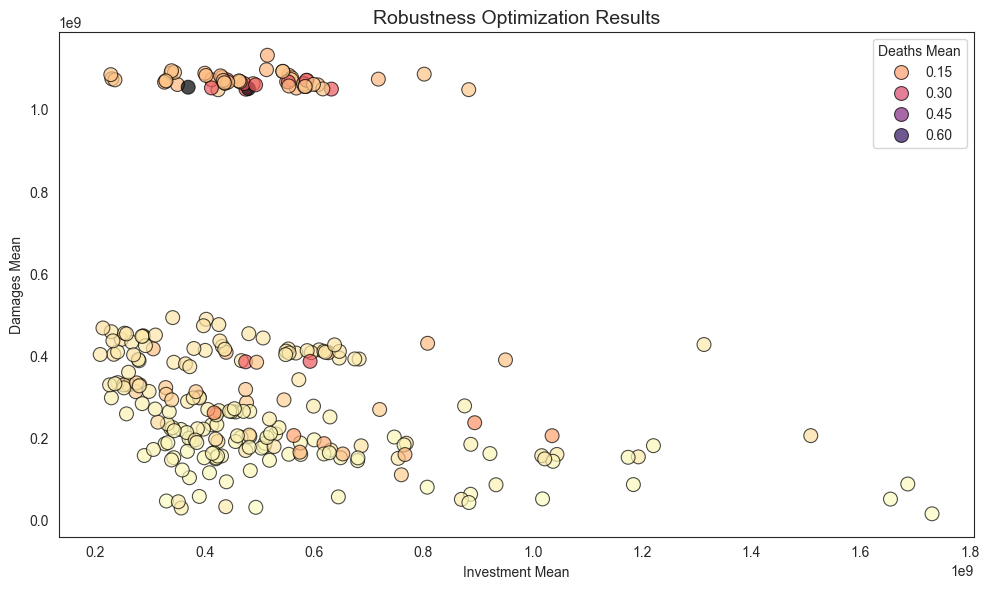

In [18]:
# Optional: rename columns for clarity if needed
df = robustness_metrics.rename(columns={
    'investment_mean': 'Investment Mean',
    'damage_mean': 'Damages Mean',
    'deaths_mean': 'Deaths Mean'
})

# Plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='Investment Mean',
    y='Damages Mean',
    hue='Deaths Mean',
    palette='magma_r',
    s=100,
    alpha=0.7,
    edgecolor='black'
)

plt.title("Robustness Optimization Results", fontsize=14)
plt.legend(title='Deaths Mean')
plt.tight_layout()
plt.show()

We filtered so that all policies should minimize but have less than 3 locations of RfR and Dikeincrease as this will not be politically viable as there will unevitably be stakeholders that will not want RfR or dikeheightening. This is according to Rijkswaterstaat's mandate that states that it should propose a policy that will not be vetoed by any other stakeholders and pass through. 

In case this prediction is wrong we also gave the overall best performing policy based on it being the least in all outcomes

In [60]:
# Identify all RfR and DikeIncrease columns
rfr_cols = [col for col in robustness_metrics.columns if 'rfr' in col.lower()]
dike_cols = [
    col for col in robustness_metrics.columns if 'dikeincrease' in col.lower()]

# Mask for policies where all RfR and DikeIncrease levers are below 3
lever_mask = (robustness_metrics[rfr_cols] < 3).all(
    axis=1) & (robustness_metrics[dike_cols] < 3).all(axis=1)
df_lever_filtered = robustness_metrics[lever_mask].copy()

# Normalize and compute composite score for lever-filtered policies
for col in ['deaths_mean', 'investment_mean', 'damage_mean']:
    df_lever_filtered[col + '_norm'] = (df_lever_filtered[col] - df_lever_filtered[col].min()) / (
        df_lever_filtered[col].max() - df_lever_filtered[col].min())
df_lever_filtered['composite_score'] = df_lever_filtered[[
    'deaths_mean_norm', 'investment_mean_norm', 'damage_mean_norm']].sum(axis=1)

# Select 4 best lever-filtered policies
policies_lever = df_lever_filtered.nsmallest(4, 'composite_score')

# Now select 1 policy that just minimizes everything (regardless of levers)
df_all = robustness_metrics.copy()
for col in ['deaths_mean', 'investment_mean', 'damage_mean']:
    df_all[col + '_norm'] = (df_all[col] - df_all[col].min()) / \
        (df_all[col].max() - df_all[col].min())
df_all['composite_score'] = df_all[['deaths_mean_norm',
                                    'investment_mean_norm', 'damage_mean_norm']].sum(axis=1)
policy_any = df_all.nsmallest(1, 'composite_score')

# Combine, allowing for possible duplicates
selected_policies = pd.concat(
    [policies_lever, policy_any]).reset_index(drop=True)

print("Selected policies (4 with all RfR and DikeIncrease < 3, 1 best overall):")
print(selected_policies)

Selected policies (4 with all RfR and DikeIncrease < 3, 1 best overall):
       policy  investment_mean   damage_mean  deaths_mean  deaths_mean_norm  \
0  policy_202     3.297607e+08  4.688717e+07     0.004456          0.001326   
1  policy_222     3.568776e+08  2.983518e+07     0.026040          0.031281   
2  policy_230     3.515830e+08  4.506465e+07     0.030886          0.038007   
3   policy_32     3.899644e+08  5.801449e+07     0.006577          0.004269   
4  policy_202     3.297607e+08  4.688717e+07     0.004456          0.001326   

   investment_mean_norm  damage_mean_norm  composite_score  
0              0.079563          0.027907         0.108796  
1              0.097377          0.012650         0.141307  
2              0.093899          0.026277         0.158182  
3              0.119112          0.037863         0.161244  
4              0.079563          0.027907         0.108796  


In [61]:
# Make sure selected_policy_ids is already defined (from previous step)
# It's a list of strings like ['policy_123', 'policy_78', ...]

# Extract numeric index from policy names
selected_indices = [int(p.split('_')[1]) for p in selected_policy_ids]

# Get the rows corresponding to those policies from pareto_policies
selected_levers = pareto_policies.iloc[selected_indices]

# Show lever settings
print("Lever settings for the selected policies:")
display(selected_levers)

Lever settings for the selected policies:


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,3_RfR 1,3_RfR 2,4_RfR 0,4_RfR 1,4_RfR 2,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,3,0,8,3,0,8,5,6,6,7,5,5,1,0,5.196403e+06,4.933509e+08,0.000000e+00,316.010739,0.000601
4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3,4,0,0,6,0,0,10,0,0,3,3,1,7,0,0,2.295215e+07,2.278375e+08,6.140000e+07,906.076692,0.002241
237,1,1,0,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,0,9,0,0,4,0,0,3,0,0,4,0,0,0.000000e+00,1.582259e+08,1.572700e+09,0.000000,0.000000
202,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,3,6,0,0,6,0,0,5,0,0,6,3,5,7,0,0,1.399018e+07,2.376595e+08,9.210000e+07,790.892083,0.001677
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,9,0,0,10,4,0,3,0,4,3,0,0,4.529849e+07,3.059287e+08,0.000000e+00,1195.042021,0.009288


Save both the levers and the outcomes

In [62]:
#selected_levers.index.name = "Policy_id"   
#selected_levers.reset_index(inplace=True)

Final_policies = selected_levers.to_csv('Final_policies.csv', index=False)

In [63]:
Final_policies_outcomes = selected_policies.to_csv(
    'Final_policies_outcomes.csv', index=False)

In [64]:
Final_policies = pd.read_csv('Final_policies.csv')